# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [2]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Show the shape of the dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (18640, 96, 96, 3)
y shape: (18640,)


##  🦠 Process the Data


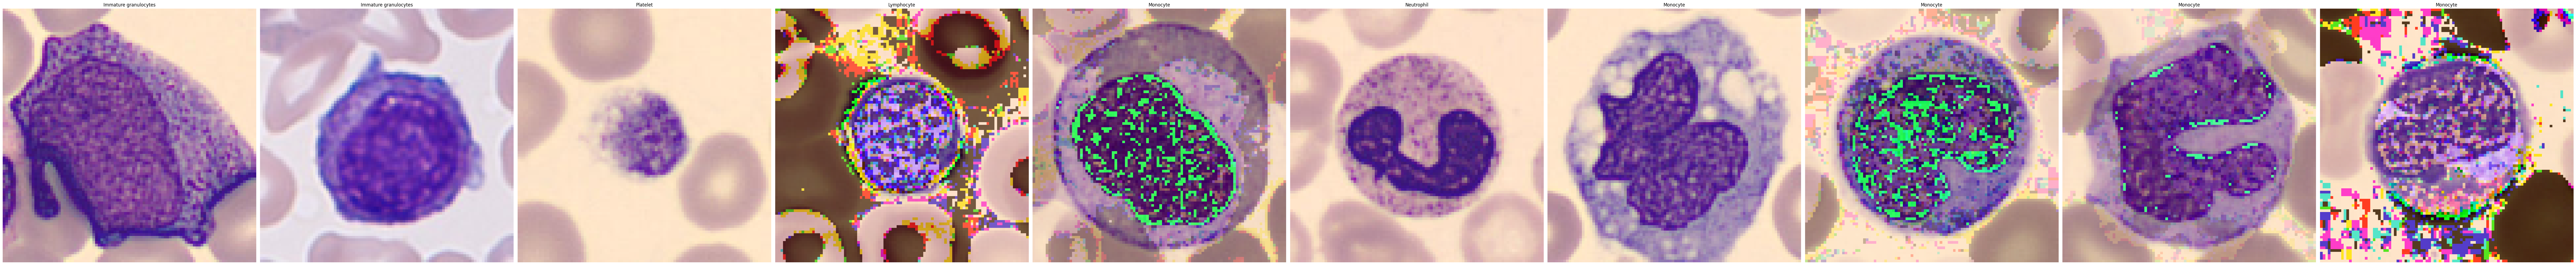

In [3]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(labels[y[idx]])
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [4]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
7    2330
3    2330
6    2330
2    2330
1    2330
5    2330
0    2330
4    2330
Name: count, dtype: int64


In [5]:
# Normalize the data to the range [0, 1] and encode output labels
X = (X / 255).astype('float32')
y = tfk.utils.to_categorical(y, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (13048, 96, 96, 3), Validation data shape: (5592, 96, 96, 3)
Training labels shape: (13048, 8), Validation labels shape: (5592, 8)


## 🔆 Agumenting the training and validation set
We use AutoContrast and RandomSaturation from the keras library for the training set. It enhances contrast adaptively and may help in highlighting subtle differences between cell types without altering structure. 
We added the agumented images to the training set & we applied some rotation, zoom and shift.

We use RandAugment for the validation set. 

In [6]:
# Import keras
import keras_cv as kcv

c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


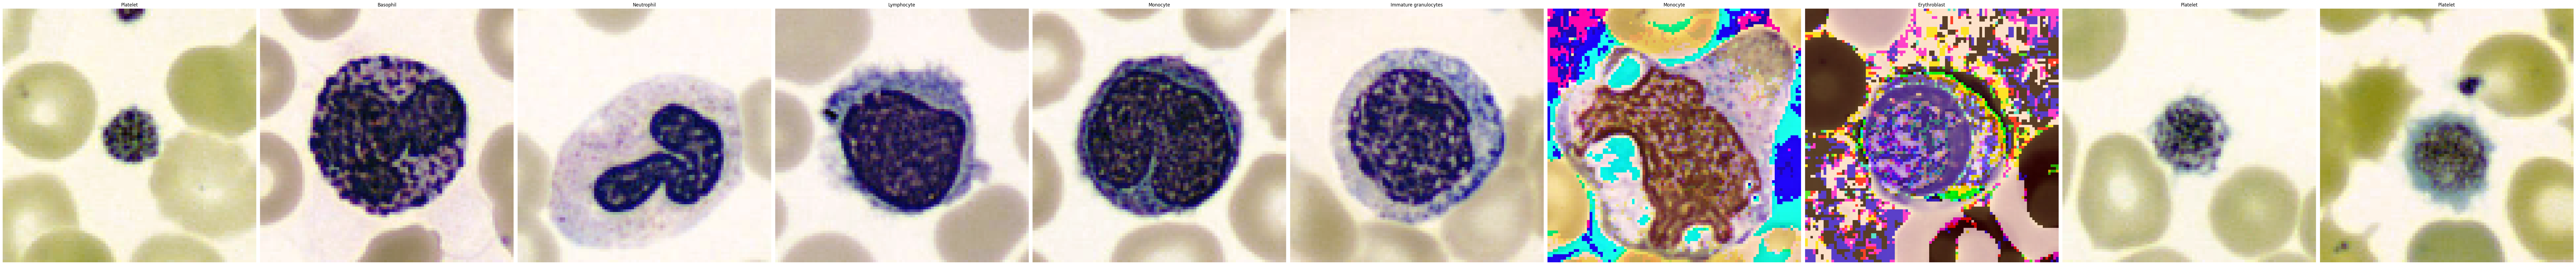

In [7]:
# Implement AutoContrast
value_range = [0, 1]
autocontrast = kcv.layers.AutoContrast(value_range)
contrast_result = autocontrast({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(contrast_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(contrast_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(contrast_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

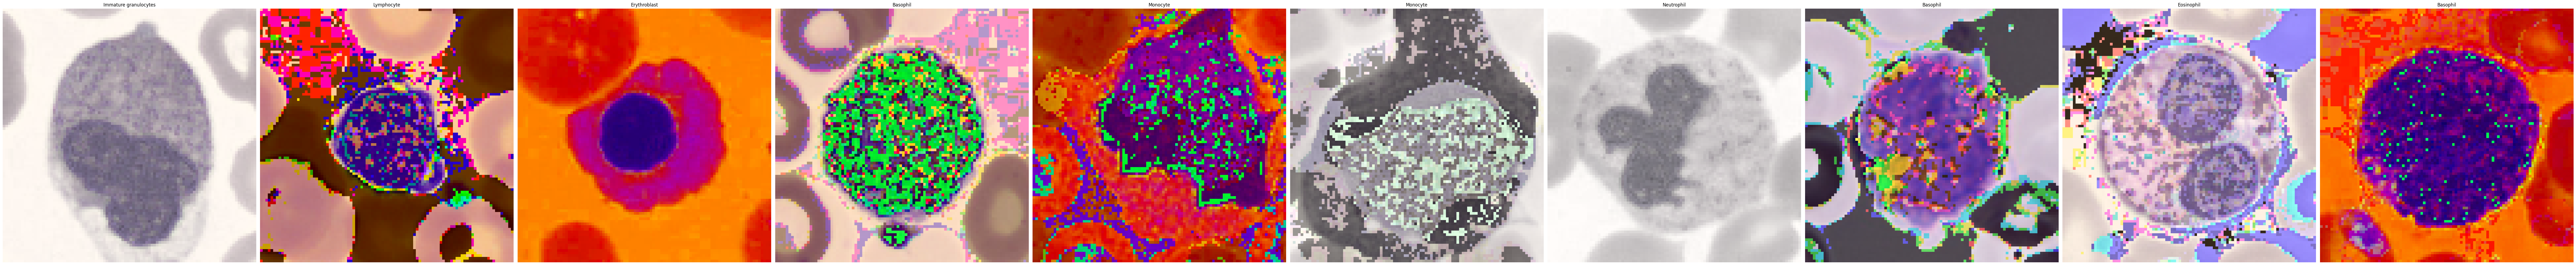

In [8]:
# Implement RandomSaturation
factor = [0, 1]
randomsaturation = kcv.layers.RandomSaturation(factor, seed=seed)
saturation_result = randomsaturation({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(saturation_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(saturation_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(saturation_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Add the result of the augmentatation to the original training set
X_train = np.concatenate((X_train, contrast_result["images"]), axis=0)
y_train = np.concatenate((y_train, contrast_result["labels"]), axis=0)
X_train = np.concatenate((X_train, saturation_result["images"]), axis=0)
y_train = np.concatenate((y_train, saturation_result["labels"]), axis=0)

# Inspect the target
print('Counting occurrences of target classes:')
y_train_indices = np.argmax(y_train, axis=1) #
print(pd.DataFrame(y_train_indices, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
0    4893
1    4893
3    4893
7    4893
5    4893
4    4893
6    4893
2    4893
Name: count, dtype: int64


val_agumented shape: (5592, 96, 96, 3)
y_val shape: (5592, 8)


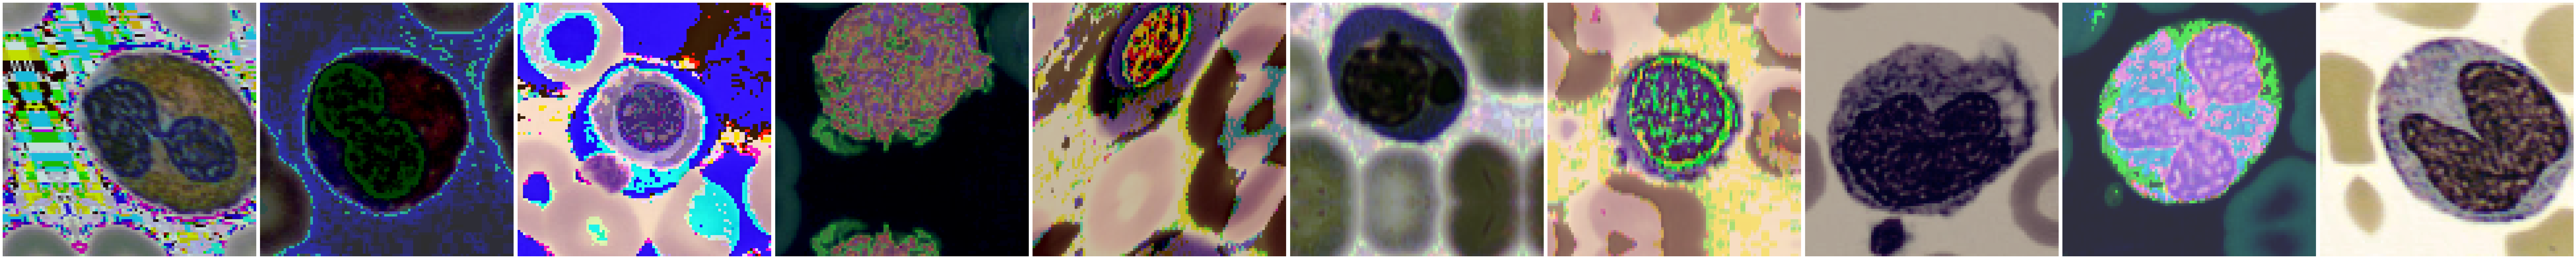

In [10]:
# Augmenting validation set
randaugment = kcv.layers.RandAugment(value_range=(0,1), augmentations_per_image=3, magnitude=0.3)
val_augmented = randaugment(X_val)
print("val_agumented shape:", val_augmented.shape)
print("y_val shape:", y_val.shape)

# Show some images
num_img = 10
random_indices = random.sample(range(len(val_augmented)), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(val_augmented[idx]), vmin=0., vmax=1.)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,         # Equivalent to RandomRotation
    width_shift_range=0.2,     # Equivalent to RandomTranslation on x-axis
    height_shift_range=0.2,    # Equivalent to RandomTranslation on y-axis
    zoom_range=0.2,            # Equivalent to RandomZoom
    horizontal_flip=True,      # Equivalent to RandomFlip (horizontal)
    vertical_flip=True         # Equivalent to RandomFlip (vertical)
)

train_generator = datagen.flow(X_train, y_train)

## Transfer Learning

In [12]:
# Initialise densenet model with pretrained weights, for transfer learning
dense = tfk.applications.densenet.DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    classifier_activation='softmax'
)

# Display a summary of the model architecture
# dense.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(dense, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a Global Average Pooling layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
# tl_model.summary(expand_nested=True)

In [32]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
# ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [33]:
ft_model.get_layer('densenet121').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('densenet121').layers:
    layer.trainable = False

# Enable training only for Conv2D layers
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv1_conv Conv2D True
9 conv2_block1_1_conv Conv2D True
12 conv2_block1_2_conv Conv2D True
16 conv2_block2_1_conv Conv2D True
19 conv2_block2_2_conv Conv2D True
23 conv2_block3_1_conv Conv2D True
26 conv2_block3_2_conv Conv2D True
30 conv2_block4_1_conv Conv2D True
33 conv2_block4_2_conv Conv2D True
37 conv2_block5_1_conv Conv2D True
40 conv2_block5_2_conv Conv2D True
44 conv2_block6_1_conv Conv2D True
47 conv2_block6_2_conv Conv2D True
51 pool2_conv Conv2D True
55 conv3_block1_1_conv Conv2D True
58 conv3_block1_2_conv Conv2D True
62 conv3_block2_1_conv Conv2D True
65 conv3_block2_2_conv Conv2D True
69 conv3_block3_1_conv Conv2D True
72 conv3_block3_2_conv Conv2D True
76 conv3_block4_1_conv Conv2D True
79 conv3_block4_2_conv Conv2D True
83 conv3_block5_1_conv Conv2D True
86 conv3_block5_2_conv Conv2D True
90 conv3_block6_1_conv Conv2D True
93 conv3_block6_2_conv Conv2D True
97 conv3_block7_1_conv Conv2D True
100 conv3_block7_2_conv Conv2D True
104 conv3_block8_1_conv Conv2D True
107

In [34]:
# Set the number of layers to freeze
N = 100

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('densenet121').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
#ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

0 input_layer False
1 zero_padding2d False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block

In [35]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [36]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_generator, 
    batch_size = 16,
    epochs = 6,
    validation_data = (val_augmented, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/6


c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 712s 568ms/step - accuracy: 0.4565 - loss: 1.7486 - val_accuracy: 0.7573 - val_loss: 0.7685
Epoch 2/6
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 629s 514ms/step - accuracy: 0.8648 - loss: 0.4032 - val_accuracy: 0.7666 - val_loss: 0.8901
Epoch 3/6
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 675s 551ms/step - accuracy: 0.9043 - loss: 0.2894 - val_accuracy: 0.8101 - val_loss: 0.6236
Epoch 4/6
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 687s 561ms/step - accuracy: 0.9232 - loss: 0.2368 - val_accuracy: 0.8011 - val_loss: 0.7625
Epoch 5/6
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 664s 543ms/step - accuracy: 0.9308 - loss: 0.2153 - val_accuracy: 0.7952 - val_loss: 0.8600
Epoch 6/6
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 647s 528ms/step - accuracy: 0.9326 - loss: 0.2046 - val_accuracy: 0.7945 - val_loss: 0.7601
Final validation accuracy: 81.01%


## 🛠️ Train and Save the Model

175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step


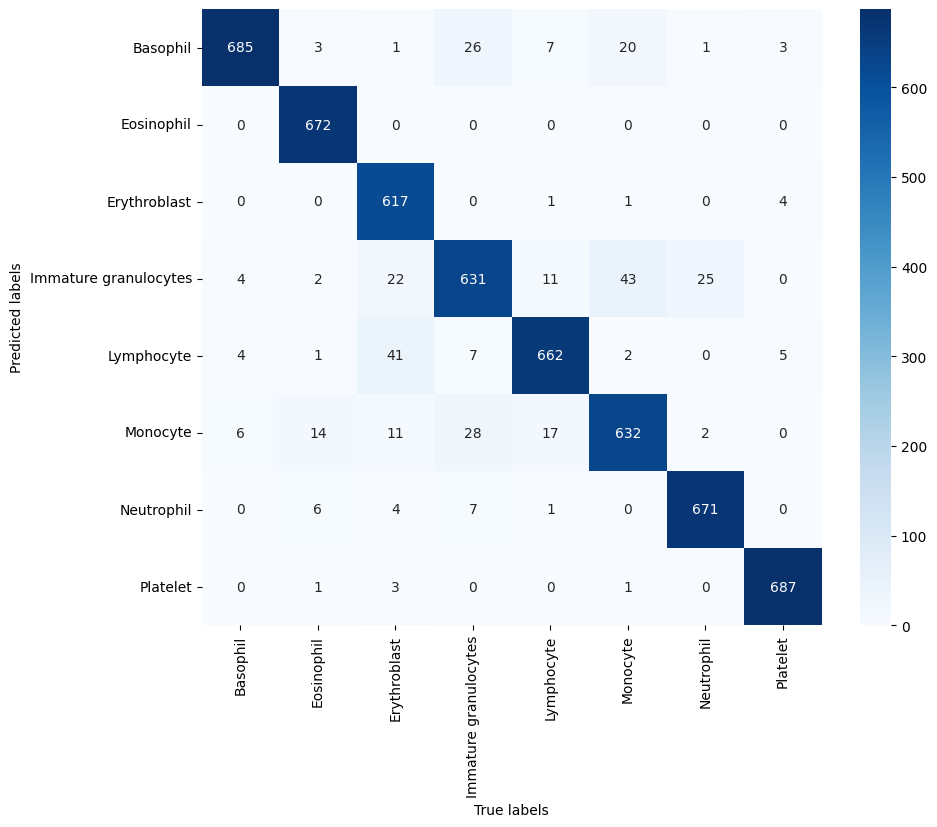

In [37]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

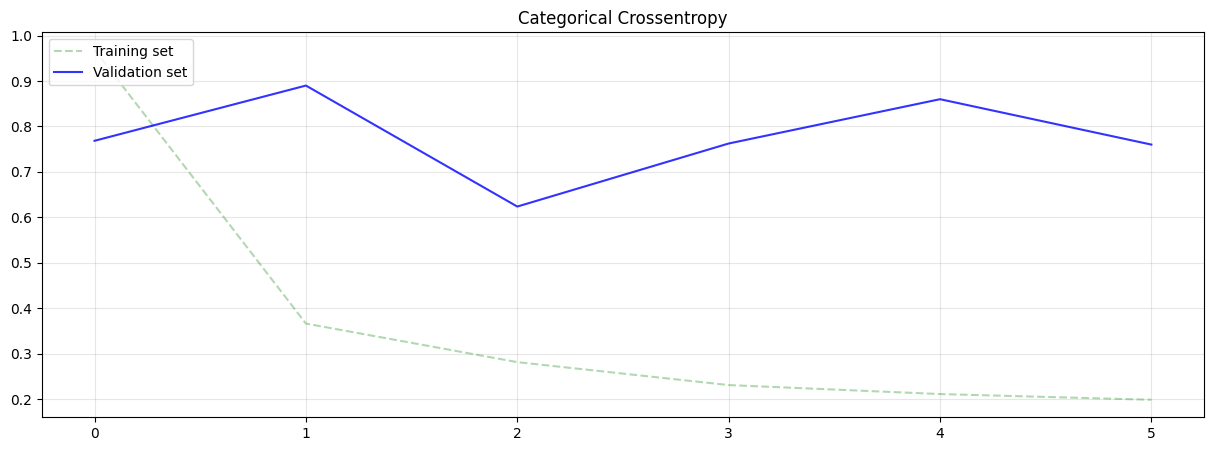

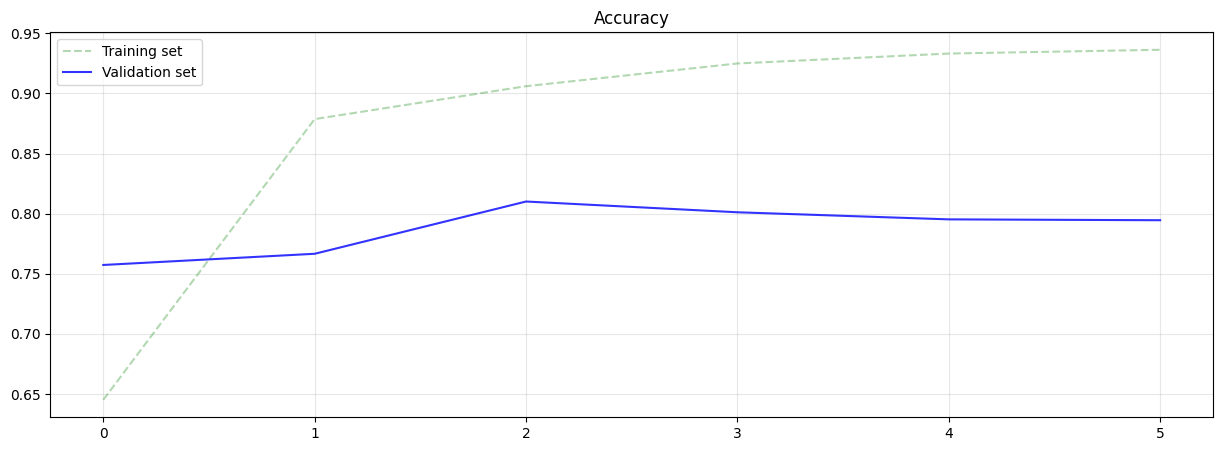

In [39]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(ft_history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [40]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [41]:
# Create the .zip file to be submitted
import os
import zipfile

# Check if model.py and weights.keras exist
if os.path.exists("model.py") and os.path.exists("weights.keras"):
    # Create a ZIP file containing model.py and weights.keras
    with zipfile.ZipFile("sub.zip", "w") as model_zip:
        model_zip.write("model.py")
        model_zip.write("weights.keras")
    print("model.zip has been created successfully.")
else:
    print("model.py or weights.keras not found. Please ensure both files are in the current directory.")

model.zip has been created successfully.
